In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
import statsmodels.stats.diagnostic as smd
from pylab import rcParams
from scipy.stats import shapiro
from statsmodels.tsa.stattools import adfuller
import MetaTrader5 as mt5
from datetime import timedelta
import datetime

#### Reino Unido - Índice PMI del sector servicios

El Indice de los Gerentes de Compra del Chartered Institute of Purchasing and Supply (CIPS), mide el nivel de actividad de los gerentes de compra en el sector servicios.
Cualquier lectura por encima de 50 indica expansión, mientras que una lectura por debajo de 50 indica contracción. < BR /> Da una indicación acerca de la salud de la industria de servicios en el Reino Unido. Los comerciantes ven de cerca estas encuestas ya que, como jefes de compras, por lo general tienen un acceso fácil a datos sobre el rendimiento de su empresa, lo que puede ser un indicador de los resultados económicos globales.
Un mayor lectura de la esperada debe ser tomada como positiva / alcista para el GBP, mientras que una lectura inferior a lo esperado debería ser tomada como negativa y bajista para el GBP.

In [2]:
pmi = pd.read_excel("Indice PMI sector servicios GBP.xlsx")

def Replace(str1):
    maketrans = str1.maketrans
    final = str1.translate(maketrans(',.', '.,', ' '))
    return final.replace(',', ", ")

actual = [float(Replace(pmi["Actual"][i])) for i in range(0, len(pmi["Actual"]))]
prevision = [float(Replace(pmi["Prevision"][i])) for i in range(0, len(pmi["Prevision"]))]
anterior = [float(Replace(pmi["Anterior"][i])) for i in range(0, len(pmi["Anterior"]))]
temp = [pmi["Fecha de publicacion"][i].replace(".","-") for i in range(0, len(pmi["Fecha de publicacion"]))]
temp = ["{2}-{1}-{0}".format(*temp[i].split('-')) for i in range(0,len(temp))]
fecha = [datetime.datetime.strptime(temp[i], "%Y-%m-%d") for i in range(0, len(temp))]

hours = []
for i in pmi["Hora"]:
    if isinstance(i,datetime.time):
        hours.append(i)
    else:
        hours.append(datetime.datetime.strptime(i.strip(), '%H:%M').time())

pmi["Actual"] = actual
pmi["Prevision"] = prevision
pmi["Anterior"] = anterior
pmi["Fecha de publicacion"] = fecha
pmi["Hora"] = hours
pmi.set_index("Fecha de publicacion", inplace=True);

In [3]:
pmi.head()

,Hora,Actual,Prevision,Anterior
Fecha de publicacion,,,,
2021-05-06,10:30:00,61.0,60.1,56.3
2021-04-07,10:30:00,56.3,56.8,49.5
2021-03-24,11:30:00,56.8,51.0,49.5
2021-03-03,11:30:00,49.5,49.7,39.5
2021-02-19,11:30:00,49.7,41.0,39.5


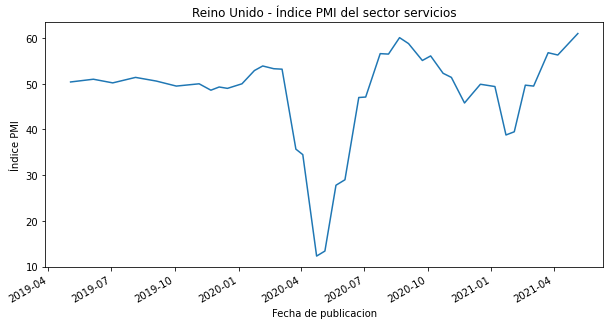

In [4]:
pmi["Actual"].plot(figsize=(10,5));
plt.ylabel("Índice PMI");
plt.title("Reino Unido - Índice PMI del sector servicios");

#### 1. Componente de Autocorrelación y Autocorrelación Parcial

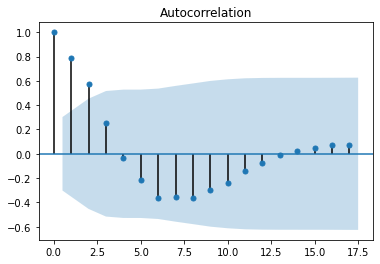

In [5]:
plot_acf(pmi["Actual"]);

Componente de autocorrelación igual a 2.5

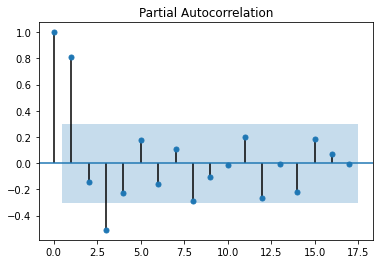

In [6]:
plot_pacf(pmi["Actual"]);

Componente de autocorrelación parcial igual a 1

#### 2. Prueba de Heterocedasticidad

In [7]:
def reglin(x,y):
    x = sm.add_constant(x)
    model = sm.OLS(y,x).fit()
    B0 = model.params[0]
    B1 = model.params[1]
    x = x[:, 1]
    
    x2 = np.linspace(x.min(), x.max(),100)
    y_hat = x2 * B1 + B0
    plt.scatter(x, y, alpha=1)
    plt.plot(x2, y_hat, "r", alpha=1)
    plt.xlabel("Tiempo")
    plt.ylabel("PMI")
    return model, B0, B1

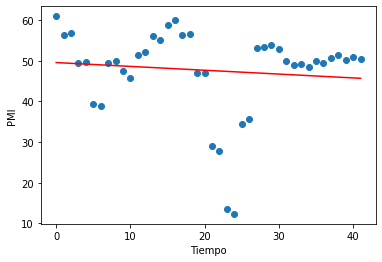

In [8]:
pmi.reset_index(inplace=True)
reglin(pmi.index, pmi["Actual"])
pmi.set_index("Fecha de publicacion", inplace=True)
#plt.title("Regresión lineal")

#### 3. Prueba de Normalidad

In [9]:
stat, p = shapiro(pmi["Actual"])
alpha = 0.05
if p > alpha:
    print('Es normal')
else:
    print('No es normal')

No es normal


#### 4. Estacionalidad

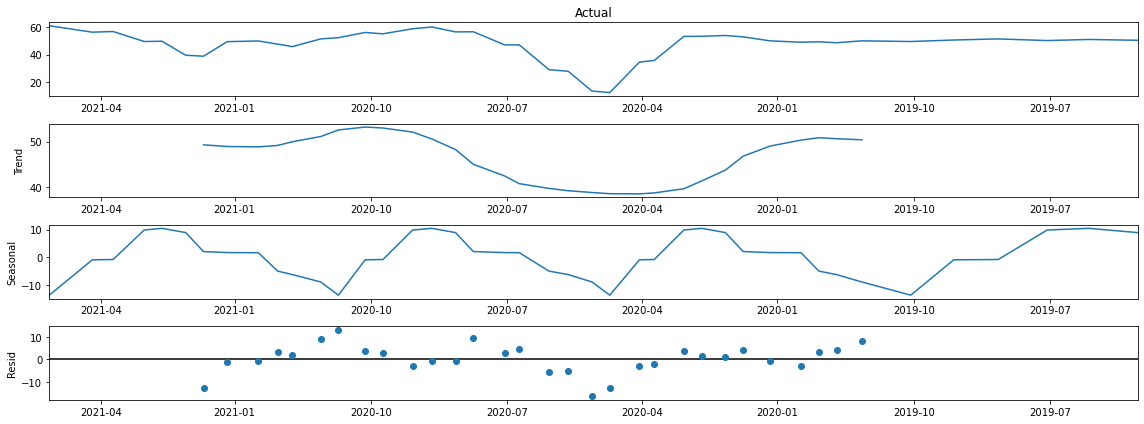

In [10]:
rcParams['figure.figsize'] = 16, 6
decomposition = sm.tsa.seasonal_decompose(pmi["Actual"], model='additive', period=12)
fig = decomposition.plot()
plt.show()

#### 5. Estacionariedad

In [11]:
def estacionariedad(serie_de_tiempo):
    ## Test de DICKEY-FULLER
    adf_test = adfuller(serie_de_tiempo)
    if adf_test[1] > 0.05:
        print("No es estacionaria")
    else:
        print("Es estacionaria")

In [12]:
estacionariedad(pmi["Actual"])

No es estacionaria


#### 6. Detección de Atípicos

Text(0.5, 1.0, 'Detección de Atípicos')

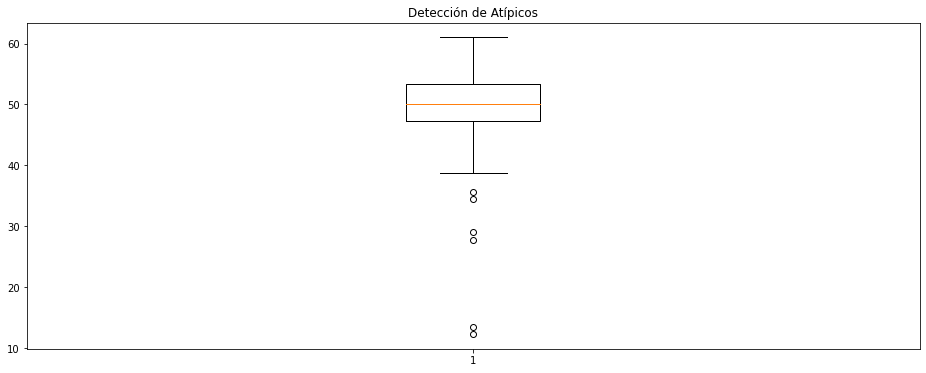

In [13]:
plt.boxplot(pmi["Actual"]);
plt.title("Detección de Atípicos")

#### Precios Históricos

In [125]:
gbp_usd_2019 = pd.read_csv("DAT_MT_GBPUSD_M1_2019.csv")
gbp_usd_2020 = pd.read_csv("DAT_MT_GBPUSD_M1_2020.csv")
gbp_usd_2021_e = pd.read_excel("DAT_XLSX_GBPUSD_M1_202101.xlsx")
gbp_usd_2021_f = pd.read_excel("DAT_XLSX_GBPUSD_M1_202102.xlsx")
gbp_usd_2021_m = pd.read_excel("DAT_XLSX_GBPUSD_M1_202103.xlsx")
gbp_usd_2021_a = pd.read_excel("DAT_XLSX_GBPUSD_M1_202104.xlsx")

temp = [gbp_usd_2019["Fecha"][i].replace(".","-") for i in range(0, len(gbp_usd_2019["Fecha"]))]
fecha_2019 = [datetime.datetime.strptime(temp[i], "%Y-%m-%d") for i in range(0, len(temp))]

hours_2019 = []
for i in gbp_usd_2019["Hora"]:
    if isinstance(i,datetime.time):
        hours_2019.append(i)
    else:
        hours_2019.append(datetime.datetime.strptime(i.strip(), '%H:%M').time())
        
gbp_usd_2019["Fecha"] = fecha_2019
gbp_usd_2019["Hora"] = hours_2019

temp = [gbp_usd_2020["Fecha"][i].replace(".","-") for i in range(0, len(gbp_usd_2020["Fecha"]))]
fecha_2020 = [datetime.datetime.strptime(temp[i], "%Y-%m-%d") for i in range(0, len(temp))]

hours_2020 = []
for i in gbp_usd_2020["Hora"]:
    if isinstance(i,datetime.time):
        hours_2020.append(i)
    else:
        hours_2020.append(datetime.datetime.strptime(i.strip(), '%H:%M').time())
        
gbp_usd_2020["Fecha"] = fecha_2020
gbp_usd_2020["Hora"] = hours_2020

fechayhora_2019 = [datetime.datetime.combine(gbp_usd_2019["Fecha"][i], gbp_usd_2019["Hora"][i]) for i in range(0, len(gbp_usd_2019["Fecha"]))]
gbp_usd_2019["Fecha"] = fechayhora_2019
gbp_usd_2019.drop(["Hora"], axis=1, inplace=True)
gbp_usd_2019.rename(columns={"Fecha": "Fecha y hora"}, inplace=True)

fechayhora_2020 = [datetime.datetime.combine(gbp_usd_2020["Fecha"][i], gbp_usd_2020["Hora"][i]) for i in range(0, len(gbp_usd_2020["Fecha"]))]
gbp_usd_2020["Fecha"] = fechayhora_2020
gbp_usd_2020.drop(["Hora"], axis=1, inplace=True)
gbp_usd_2020.rename(columns={"Fecha": "Fecha y hora"}, inplace=True)

frames = [gbp_usd_2019, gbp_usd_2020, gbp_usd_2021_e, gbp_usd_2021_f, gbp_usd_2021_m, gbp_usd_2021_a]
precios_gbp_usd = pd.concat(frames)
precios_gbp_usd.set_index("Fecha y hora", inplace=True)

In [127]:
precios_gbp_usd.head()

,Open,High,Low,Close
Fecha y hora,,,,
2019-01-01 17:06:00,1.27459,1.27459,1.27250,1.27250
2019-01-01 17:11:00,1.27227,1.27227,1.27227,1.27227
2019-01-01 17:12:00,1.27294,1.27294,1.27294,1.27294
2019-01-01 17:13:00,1.27294,1.27295,1.27294,1.27295
2019-01-01 17:14:00,1.27295,1.27295,1.27277,1.27277
